<a href="https://colab.research.google.com/github/davidashirov/uzum_biz_an/blob/main/kNN_torch_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ускоряем kNN - Качок Доге стайл
## Поменяй сервер на GPU!

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Pytorch&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                / &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Scikit-learn

<img src="https://i.kym-cdn.com/entries/icons/original/000/034/084/cover6.jpg" alt="image" width="700" height="auto">


Scikit-learn медленный, потому что использует numpy/scipy для манипуляции массивами. Мы напишем свой kNN и используем Pytorch тензор и посмотрим кто окажется быстрее.

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')

11490434/11490434 [==============================] - 0s 0us/step
x_train.shape=(60000, 28, 28) y_train.shape=(60000,)
x_test.shape=(10000, 28, 28) y_test.shape=(10000,)


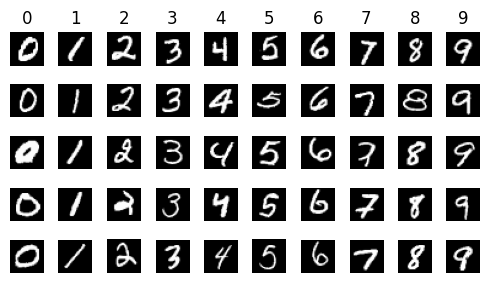

In [3]:
import matplotlib.pyplot as plt
# Plot the first few images
fig, axes = plt.subplots(5, 10, figsize=(5, 3))
for i in np.arange(0, 10):
  axes[0,i].set_title(i)
  for j in np.arange(0,5):
    digit = np.random.randint(x_train[y_train==i].shape[0])
    axes[j,i].imshow(x_train[y_train==i][digit], cmap='gray')
    axes[j,i].axis('off')
plt.tight_layout()

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class kNN():
  def __init__(self, n_neighbors,weights='uniform',*args, **kwargs):
    self.n_neighbors = n_neighbors
    self.weights = weights

  def fit(self, X, y):
    self.X = torch.tensor(X,device=device,dtype=torch.float32)
    self.y = torch.tensor(y,device=device)

  def predict_proba(self, X_test):
    X_test = torch.tensor(X_test,device=device,dtype=torch.float32)
    X = self.X
    y = self.y

    distances = torch.cdist(X, X_test, p=2.0)
    distances_n_nearest, indices = torch.topk(distances, n_neighbors, largest=False, dim=0)

    n_nearest = y[indices] # N nearest digits: n, 10000 tensor
    digits = torch.arange(10,device=device)[:, None, None] # Digits 1-9: 10, 1, 1 tensor
    digit_counts_bool = (n_nearest==digits).to(device) # Broadcasting: 10, n, 10000 tensor

    if weights=='uniform':
      class_probas = digit_counts_bool.mean(dim=1, dtype=torch.float16) # collapse to 10,10000 tensor

    elif weights=='distance':
      # Inverse distance weights
      w = 1/distances_n_nearest # n, 10000
      # sum weights along dimension of nearest points
      sum_w = w.sum(dim=0,keepdim=True)  # 1, 10000
      # multiply each count by its weight and sum along counts dimension leaving 10, 10000 tensor
      class_probas = (digit_counts_bool*w).sum(dim=1)/sum_w # 10,n,10000 * 1,10000 -sum-> 10, 10000
    else:
      raise NotImplementedError()

    return class_probas

  def predict(self, X_test):
    probas = self.predict_proba(X_test)
    pred_classes = probas.argmax(dim=0) # Find class with highest prob
    return pred_classes

In [5]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 5
weights = 'distance'
knn_torch = kNN(n_neighbors,weights)
knn_sk = KNeighborsClassifier(n_neighbors=3)

# Мой kNN написанный на Pytorch
knn_torch.fit(x_train.reshape(x_train.shape[0],-1), y_train)

# Scikit learn
knn_sk.fit(x_train.reshape(x_train.shape[0],-1), y_train)

KNeighborsClassifier(n_neighbors=3)

In [6]:
%%time
y_pred = knn_torch.predict(x_test.reshape(x_test.shape[0],-1))

CPU times: user 437 ms, sys: 280 ms, total: 717 ms
Wall time: 2.91 s


In [7]:
%%time
y_pred = knn_sk.predict(x_test.reshape(x_test.shape[0],-1))

CPU times: user 39 s, sys: 3.8 s, total: 42.8 s
Wall time: 32.2 s


Я пытался заставить работать поиск гиперпараметров для kNN класса на Pytorch, но это требует еще нескольких методов. Я их попытался написать, но почему-то оно все равно возвращало NaN. Я сдался и буду искать гиперпараметры используя модель scikit learn.

In [14]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn_sk,
                          {'n_neighbors':list(range(5,20,1))},
                           verbose=1,
                           cv=2)
grid_search.fit(x_train.reshape(x_train.shape[0],-1), y_train)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


GridSearchCV(cv=2, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19]},
             verbose=1)

In [15]:
grid_search.best_params_

{'n_neighbors': 5}